In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [4]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [5]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_74189/ipykernel_74262/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


## BH data

In [6]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better_fixed_fluxes.csv")
Best_Heckman_data['Source'] = 'BH'

In [7]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [8]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [9]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_74189/ipykernel_74262/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [10]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [11]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [12]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [13]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [14]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [15]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [16]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_74189/ipykernel_74262/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [17]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [18]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

# Add 2class columns

In [19]:
def AGN(row):
    
    if row['Classification'] == 'jet-mode radio AGN/low-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'radio-quiet AGN':
        return 1
    elif row['Classification'] == 'star-forming galaxy':
        return 0

In [20]:
# Temporarily relabelling it for function
y['Classification'] = le.inverse_transform(y['Classification'])
y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')
y['Classification'] = le.transform(y['Classification'])

In [21]:
y

,Classification,Source,Xray,Opt_spec,IRAGN,Donley,XAGN,midIRAGN,VLBAAGN,RLAGN,optAGN,AGN
0,3,Original,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0
1,1,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
2,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
3,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
4,2,Original,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95136,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0
95137,1,MIGHTEE,NaN,NaN,NaN,NaN,True,False,False,True,False,1
95138,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0
95139,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'AGN']], random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'AGN']], random_state=42)

# Step 1: AGN or not

In [54]:
from bayes_opt import BayesianOptimization

In [65]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta
                    ):
    # The algorithm gives floats, so we round them
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      eta=eta,
                      tree_method='hist',
                      eval_metric =['logloss'],
                      nthread=8,
                      n_estimators=10**5
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                    stratify=y_test_cv, random_state=42)

        # Training the model
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                    eval_set=[
                        (X_val_cv, y_val_cv)
                    ], 
                    early_stopping_rounds=50
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_test_cv)
        y_preds.append(accuracy_score(y_test_cv, y_pred))
    return np.mean(y_preds)

In [66]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (5, 7),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 30),
    'min_child_weight': (0, 10),
    'eta': (0.01, 0.8),
}

In [67]:
from sklearn.model_selection import StratifiedKFold

# Getting k folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y['AGN'], train_size=0.8, stratify=y[['Source', 'AGN']], random_state=42)

skf = StratifiedKFold(n_splits=8)

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [68]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [69]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=15,
        n_iter=100,
    )

|   iter    |  target   |    eta    | max_depth | min_ch... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
| 1         | 0.9084    | 0.3059    | 6.901     | 7.32      | 5.987     | 4.681     |
| 2         | 0.9091    | 0.1332    | 5.116     | 8.662     | 6.011     | 21.24     |
| 3         | 0.9093    | 0.02626   | 6.94      | 8.324     | 2.123     | 5.455     |
| 4         | 0.9087    | 0.1549    | 5.608     | 5.248     | 4.319     | 8.737     |
| 5         | 0.9064    | 0.4934    | 5.279     | 2.921     | 3.664     | 13.68     |
| 6         | 0.9028    | 0.6303    | 5.399     | 5.142     | 5.924     | 1.394     |
| 7         | 0.9065    | 0.49      | 5.341     | 0.6505    | 9.489     | 28.97     |
| 8         | 0.904     | 0.6486    | 5.609     | 0.9767    | 6.842     | 13.2      |
| 9         | 0.9098    | 0.1064    | 5.99      | 0.3439    | 9.093     | 7.763     |
| 10        | 0.9052    | 0.5334    | 5.623     | 5.20


KeyboardInterrupt



In [92]:
from flaml import AutoML
automl = AutoML()

In [60]:
import warnings

X_train, X_test, y_train, y_test = train_test_split(X, y['AGN'], train_size=0.8, stratify=y[['Source', 'AGN']], random_state=42)

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train, task="classification", metric='accuracy',
                                #X_val=X_val , y_val=y_val,
                                #ensemble=True,
                                #estimator_list=estimators, 
                                time_budget=3600, n_jobs=8,
                                eval_method='cv',
                                #log_file_name='general_extra_features3.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 02-03 11:52:01] {2390} INFO - task = classification
[flaml.automl: 02-03 11:52:01] {2392} INFO - Data split method: stratified
[flaml.automl: 02-03 11:52:01] {2396} INFO - Evaluation method: cv
[flaml.automl: 02-03 11:52:01] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-03 11:52:01] {2605} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 02-03 11:52:01] {2897} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-03 11:52:02] {3025} INFO - Estimated sufficient time budget=10420s. Estimated necessary time budget=240s.
[flaml.automl: 02-03 11:52:02] {3072} INFO -  at 1.7s,	estimator lgbm's best error=0.2563,	best estimator lgbm's best error=0.2563
[flaml.automl: 02-03 11:52:02] {2897} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-03 11:52:03] {3072} INFO -  at 2.7s,	estimator lgbm's best error=0.2563,	best estimator lgbm's best error=0.2563
[flaml.automl: 02-03

[flaml.automl: 02-03 11:53:30] {2897} INFO - iteration 36, current learner extra_tree
[flaml.automl: 02-03 11:53:30] {3072} INFO -  at 89.8s,	estimator extra_tree's best error=0.2305,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:30] {2897} INFO - iteration 37, current learner xgboost
[flaml.automl: 02-03 11:53:31] {3072} INFO -  at 90.6s,	estimator xgboost's best error=0.1858,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:31] {2897} INFO - iteration 38, current learner xgboost
[flaml.automl: 02-03 11:53:31] {3072} INFO -  at 91.3s,	estimator xgboost's best error=0.1858,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:31] {2897} INFO - iteration 39, current learner lgbm
[flaml.automl: 02-03 11:53:37] {3072} INFO -  at 96.4s,	estimator lgbm's best error=0.0971,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:37] {2897} INFO - iteration 40, current learner xgboost
[flaml.automl: 02-03 11:53:37] {3072} INFO - 

[flaml.automl: 02-03 11:55:31] {3072} INFO -  at 211.2s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:31] {2897} INFO - iteration 74, current learner extra_tree
[flaml.automl: 02-03 11:55:35] {3072} INFO -  at 214.5s,	estimator extra_tree's best error=0.1155,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:35] {2897} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 02-03 11:55:36] {3072} INFO -  at 216.0s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:36] {2897} INFO - iteration 76, current learner lgbm
[flaml.automl: 02-03 11:55:50] {3072} INFO -  at 229.4s,	estimator lgbm's best error=0.0971,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:50] {2897} INFO - iteration 77, current learner lgbm
[flaml.automl: 02-03 11:56:11] {3072} INFO -  at 250.7s,	estimator lgbm's best error=0.0945,	best estimato

[flaml.automl: 02-03 12:07:54] {2897} INFO - iteration 111, current learner xgboost
[flaml.automl: 02-03 12:07:56] {3072} INFO -  at 956.3s,	estimator xgboost's best error=0.1047,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:07:56] {2897} INFO - iteration 112, current learner lgbm
[flaml.automl: 02-03 12:09:49] {3072} INFO -  at 1069.0s,	estimator lgbm's best error=0.0906,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:09:49] {2897} INFO - iteration 113, current learner xgboost
[flaml.automl: 02-03 12:09:50] {3072} INFO -  at 1070.0s,	estimator xgboost's best error=0.1047,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:09:50] {2897} INFO - iteration 114, current learner xgboost
[flaml.automl: 02-03 12:10:01] {3072} INFO -  at 1080.5s,	estimator xgboost's best error=0.0976,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:10:01] {2897} INFO - iteration 115, current learner xgb_limitdepth
[flaml.automl: 02-03 12:10:33] {

In [62]:
print(classification_report(automl.predict(X_test), y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9544    0.9125    0.9330     13042
           1     0.8261    0.9051    0.8638      5987

    accuracy                         0.9102     19029
   macro avg     0.8903    0.9088    0.8984     19029
weighted avg     0.9141    0.9102    0.9112     19029



## Rerunning autoML settings

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'AGN']])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'AGN']])

In [77]:
automl.best_loss_per_estimator

NameError: name 'automl' is not defined

In [85]:
automl.best_config_per_estimator['xgb_limitdepth']

NameError: name 'automl' is not defined

In [86]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=10,
                     min_child_weight=0.7667675178010714,
                     learning_rate=0.05800794560416693,
                     subsample=0.8895588746662894,
                     colsample_bylevel=0.47518959001130767,
                     colsample_bytree=0.6845612830806885,
                     reg_alpha=0.008568303724660307,
                     reg_lambda=0.05299562944920838,
                     eval_metric=['logloss', 'error'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [70]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=6,
                     min_child_weight=5.68,
                     learning_rate=0.14,
                      tree_method='hist',
                     reg_alpha=3.47,
                     reg_lambda=8.52,
                     eval_metric=['logloss'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [73]:
eval_set = [(X_train, y_train['AGN']), (X_val, y_val['AGN'])]

In [74]:
model.fit(X_train, y_train['AGN'], verbose=True, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-logloss:0.62425	validation_1-logloss:0.62574
[1]	validation_0-logloss:0.57060	validation_1-logloss:0.57287
[2]	validation_0-logloss:0.52757	validation_1-logloss:0.53129
[3]	validation_0-logloss:0.49355	validation_1-logloss:0.49806
[4]	validation_0-logloss:0.46507	validation_1-logloss:0.47088
[5]	validation_0-logloss:0.44123	validation_1-logloss:0.44821
[6]	validation_0-logloss:0.42165	validation_1-logloss:0.42984
[7]	validation_0-logloss:0.40448	validation_1-logloss:0.41368
[8]	validation_0-logloss:0.38960	validation_1-logloss:0.39978
[9]	validation_0-logloss:0.37694	validation_1-logloss:0.38787
[10]	validation_0-logloss:0.36428	validation_1-logloss:0.37582
[11]	validation_0-logloss:0.35448	validation_1-logloss:0.36688
[12]	validation_0-logloss:0.34533	validation_1-logloss:0.35848
[13]	validation_0-logloss:0.33712	validation_1-logloss:0.35141
[14]	validation_0-logloss:0.32848	validation_1-logloss:0.34344
[15]	validation_0-logloss:0.32292	validation_1-logloss:0.33924
[1

[130]	validation_0-logloss:0.19546	validation_1-logloss:0.24628
[131]	validation_0-logloss:0.19468	validation_1-logloss:0.24583
[132]	validation_0-logloss:0.19426	validation_1-logloss:0.24578
[133]	validation_0-logloss:0.19396	validation_1-logloss:0.24558
[134]	validation_0-logloss:0.19351	validation_1-logloss:0.24529
[135]	validation_0-logloss:0.19336	validation_1-logloss:0.24518
[136]	validation_0-logloss:0.19304	validation_1-logloss:0.24488
[137]	validation_0-logloss:0.19265	validation_1-logloss:0.24472
[138]	validation_0-logloss:0.19228	validation_1-logloss:0.24449
[139]	validation_0-logloss:0.19188	validation_1-logloss:0.24426
[140]	validation_0-logloss:0.19152	validation_1-logloss:0.24397
[141]	validation_0-logloss:0.19136	validation_1-logloss:0.24394
[142]	validation_0-logloss:0.19097	validation_1-logloss:0.24383
[143]	validation_0-logloss:0.19076	validation_1-logloss:0.24374
[144]	validation_0-logloss:0.19031	validation_1-logloss:0.24353
[145]	validation_0-logloss:0.19011	valid

[259]	validation_0-logloss:0.15898	validation_1-logloss:0.23258
[260]	validation_0-logloss:0.15878	validation_1-logloss:0.23256
[261]	validation_0-logloss:0.15850	validation_1-logloss:0.23252
[262]	validation_0-logloss:0.15824	validation_1-logloss:0.23247
[263]	validation_0-logloss:0.15804	validation_1-logloss:0.23237
[264]	validation_0-logloss:0.15782	validation_1-logloss:0.23238
[265]	validation_0-logloss:0.15740	validation_1-logloss:0.23202
[266]	validation_0-logloss:0.15720	validation_1-logloss:0.23206
[267]	validation_0-logloss:0.15692	validation_1-logloss:0.23193
[268]	validation_0-logloss:0.15676	validation_1-logloss:0.23195
[269]	validation_0-logloss:0.15649	validation_1-logloss:0.23186
[270]	validation_0-logloss:0.15629	validation_1-logloss:0.23185
[271]	validation_0-logloss:0.15611	validation_1-logloss:0.23189
[272]	validation_0-logloss:0.15590	validation_1-logloss:0.23193
[273]	validation_0-logloss:0.15579	validation_1-logloss:0.23192
[274]	validation_0-logloss:0.15563	valid

[388]	validation_0-logloss:0.13449	validation_1-logloss:0.22712
[389]	validation_0-logloss:0.13434	validation_1-logloss:0.22704
[390]	validation_0-logloss:0.13410	validation_1-logloss:0.22691
[391]	validation_0-logloss:0.13397	validation_1-logloss:0.22687
[392]	validation_0-logloss:0.13386	validation_1-logloss:0.22687
[393]	validation_0-logloss:0.13370	validation_1-logloss:0.22685
[394]	validation_0-logloss:0.13358	validation_1-logloss:0.22678
[395]	validation_0-logloss:0.13347	validation_1-logloss:0.22679
[396]	validation_0-logloss:0.13329	validation_1-logloss:0.22673
[397]	validation_0-logloss:0.13314	validation_1-logloss:0.22667
[398]	validation_0-logloss:0.13294	validation_1-logloss:0.22669
[399]	validation_0-logloss:0.13269	validation_1-logloss:0.22664
[400]	validation_0-logloss:0.13251	validation_1-logloss:0.22672
[401]	validation_0-logloss:0.13239	validation_1-logloss:0.22667
[402]	validation_0-logloss:0.13229	validation_1-logloss:0.22663
[403]	validation_0-logloss:0.13204	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric=['logloss'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.14, max_delta_step=0,
              max_depth=6, min_child_weight=5.68, missing=nan,
              monotone_constraints='()', n_estimators=100000, n_jobs=8,
              nthread=8, num_parallel_tree=1, random_state=42, reg_alpha=3.47,
              reg_lambda=8.52, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

(0.0, 0.7)

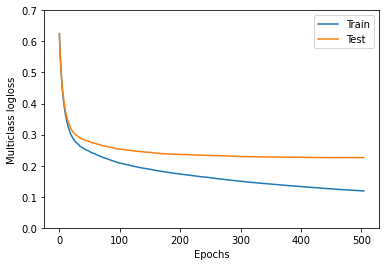

In [77]:
hist = model.evals_result()
plt.plot(hist['validation_0']['logloss'], label='Train')
plt.plot(hist['validation_1']['logloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()
plt.ylim(0,0.7)

In [76]:
print(classification_report(model.predict(X_test), y_test['AGN'], digits=4))

              precision    recall  f1-score   support

           0     0.9511    0.9189    0.9347     10324
           1     0.8405    0.9004    0.8694      4899

    accuracy                         0.9130     15223
   macro avg     0.8958    0.9097    0.9021     15223
weighted avg     0.9155    0.9130    0.9137     15223



In [81]:
i=2

filt = y_test['Source']==y_test.Source.unique()[i]
print(y_test.Source.unique()[i])
print(classification_report(model.predict(X_test[filt]), y_test['AGN'][filt], digits=4))

MIGHTEE
              precision    recall  f1-score   support

           0     0.8658    0.8217    0.8431       471
           1     0.6680    0.7380    0.7012       229

    accuracy                         0.7943       700
   macro avg     0.7669    0.7798    0.7722       700
weighted avg     0.8011    0.7943    0.7967       700



In [82]:
for i in range(4):

    filt = y_test['Classification']==i
    print(le.classes_[i])
    print("Accuracy=",accuracy_score(model.predict(X_test[filt]), y_test['AGN'][filt]))
    print("---------------------------------------------------")

jet-mode radio AGN/low-excitation radio galaxy
Accuracy= 0.8784545210625168
---------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy
Accuracy= 0.8947368421052632
---------------------------------------------------
radio-quiet AGN
Accuracy= 0.7048346055979644
---------------------------------------------------
star-forming galaxy
Accuracy= 0.951077694235589
---------------------------------------------------


In [37]:
y_test.Classification.unique()

array([3, 0, 1, 2])

In [82]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

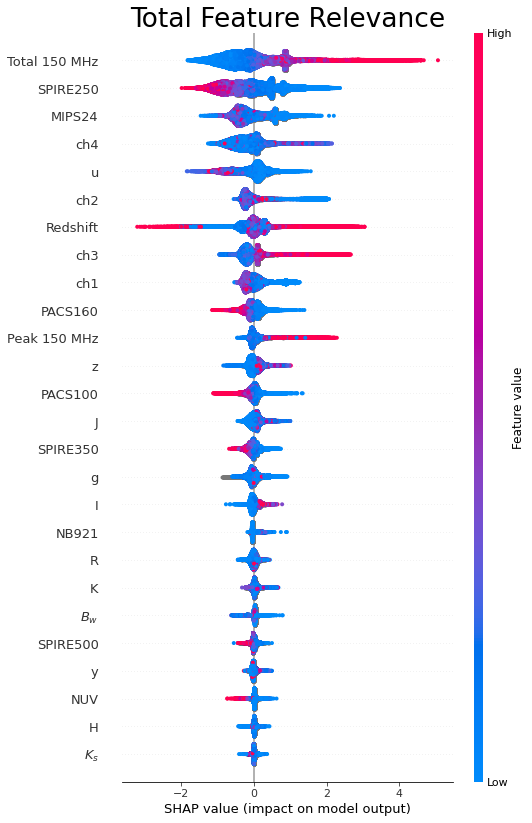

In [83]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance")
plt.tight_layout()

# Step 2: Subclasses

In [84]:
from bayes_opt import BayesianOptimization

In [85]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta
                    ):
    # The algorithm gives floats, so we round them
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      eta=eta,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric =['mlogloss'],
                      nthread=8,
                      n_estimators=10**5
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                    stratify=y_test_cv, random_state=42)

        # Training the model
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                    eval_set=[
                        (X_val_cv, y_val_cv)
                    ], 
                    early_stopping_rounds=50
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_test_cv)
        y_preds.append(accuracy_score(y_test_cv, y_pred))
    return np.mean(y_preds)

In [86]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (5, 7),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 30),
    'min_child_weight': (0, 10),
    'eta': (0.01, 0.8),
}

In [94]:
from sklearn.model_selection import StratifiedKFold

y_sub = y[y.Classification!=3]
X_sub = X[y.Classification!=3]
# Getting k folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub['Classification'], train_size=0.8, stratify=y_sub[['Source', 'Classification']], random_state=42)

skf = StratifiedKFold(n_splits=8)

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [95]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [96]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=15,
        n_iter=100,
    )

|   iter    |  target   |    eta    | max_depth | min_ch... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
| 1         | 0.9246    | 0.3059    | 6.901     | 7.32      | 5.987     | 4.681     |
| 2         | 0.9242    | 0.1332    | 5.116     | 8.662     | 6.011     | 21.24     |
| 3         | 0.9239    | 0.02626   | 6.94      | 8.324     | 2.123     | 5.455     |
| 4         | 0.9246    | 0.1549    | 5.608     | 5.248     | 4.319     | 8.737     |
| 5         | 0.9243    | 0.4934    | 5.279     | 2.921     | 3.664     | 13.68     |
| 6         | 0.9233    | 0.6303    | 5.399     | 5.142     | 5.924     | 1.394     |
| 7         | 0.925     | 0.49      | 5.341     | 0.6505    | 9.489     | 28.97     |
| 8         | 0.9235    | 0.6486    | 5.609     | 0.9767    | 6.842     | 13.2      |
| 9         | 0.9242    | 0.1064    | 5.99      | 0.3439    | 9.093     | 7.763     |
| 10        | 0.9242    | 0.5334    | 5.623     | 5.20

| 58        | 0.9247    | 0.1262    | 6.203     | 8.602     | 6.881     | 27.04     |
| 59        | 0.9238    | 0.4467    | 6.33      | 2.218     | 5.09      | 1.312     |
| 60        | 0.9244    | 0.3865    | 6.534     | 1.695     | 8.102     | 17.36     |
| 61        | 0.9247    | 0.09605   | 5.533     | 1.886     | 4.736     | 3.843     |
| 62        | 0.9216    | 0.7311    | 5.825     | 4.465     | 6.913     | 27.07     |
| 63        | 0.9222    | 0.7779    | 5.953     | 9.714     | 4.429     | 14.95     |
| 64        | 0.9236    | 0.4568    | 5.478     | 1.075     | 8.463     | 28.65     |
| 65        | 0.9245    | 0.06586   | 6.51      | 4.351     | 3.658     | 27.38     |
| 66        | 0.9232    | 0.3243    | 6.716     | 9.557     | 7.11      | 17.87     |
| 67        | 0.9236    | 0.5904    | 5.519     | 8.327     | 8.58      | 19.0      |
| 68        | 0.925     | 0.5453    | 6.23      | 8.313     | 8.676     | 29.39     |
| 69        | 0.9253    | 0.1592    | 6.787     | 6.61

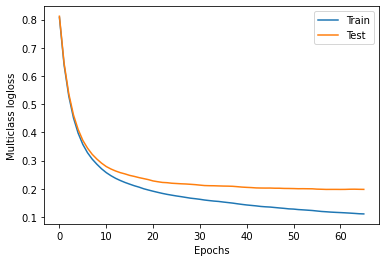

In [71]:
hist = model.evals_result()
plt.plot(hist['validation_0']['mlogloss'], label='Train')
plt.plot(hist['validation_1']['mlogloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()

In [72]:
print(classification_report(model.predict(X_test), y_test['Classification'], digits=4))

              precision    recall  f1-score   support

           0     0.9798    0.9421    0.9606      3904
           1     0.3191    0.6325    0.4242       166
           2     0.9193    0.9092    0.9142      1178

    accuracy                         0.9249      5248
   macro avg     0.7394    0.8279    0.7663      5248
weighted avg     0.9453    0.9249    0.9332      5248

